##### Optimizing the Neural Network in PyTorch
three key optimization techniques to reduce overfitting in neural networks: Dropout, Batch Normalization, and L2 Regularization

`List of Optimizations:`
1. Dropout
Explanation: Randomly deactivates neurons during training, preventing over-reliance on specific pathways and improving generalization. Inactive during evaluation.

Code: `self.dropout1 = nn.Dropout(p=0.3) self.dropout2 = nn.Dropout(p=0.3)`


2. Batch Normalization
Explanation: Normalizes layer inputs to stabilize training and accelerate convergence by reducing internal covariate shift. Applied before activation functions.

Code: `self.bn1 = nn.BatchNorm1d(128) self.bn2 = nn.BatchNorm1d(64)`

3. L2 Regularization (Weight Decay)
Explanation: Adds a penalty to the loss function based on the square of weights, encouraging smaller weights and preventing overfitting.

Code: `optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)`



In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [21]:
# Set Random seeds for reproducibility 
torch.manual_seed(42)

In [22]:
# Check for GPU 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"The current machine is using the {device}")

The current machine is using the mps


In [23]:
df = pd.read_csv('/Users/mekalathuruchenchaiah/Desktop/Programming/Deep Learing-PyTorch/data/fashion-mnist_test.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df.shape

(10000, 785)

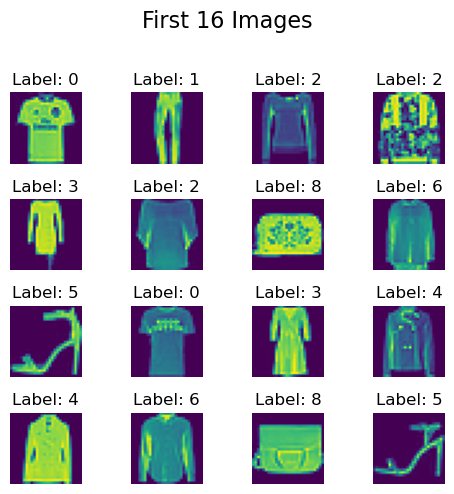

In [25]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [26]:
# Train test Split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [27]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train = X_train/255.0
X_test = X_test/255.0

In [30]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        # Convert to Pytorch tensors
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [31]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [32]:
# DataLoader : GPU speed boost	Copies batches to pinned CUDA memory (faster GPU transfer)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, pin_memory = True) # Pinned memory only for GPU's with cuda not for the MPS in macs
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=True, pin_memory = True)


In [33]:
len(train_loader)

250

In [ ]:
# Build Neural Network 
class MyNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128), # Normalizes 128-dim activations (across batch)
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Randomly zeros 30% neurons (prevents overfitting)
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [35]:
learning_rate = 0.01
epochs = 100


In [36]:
model = MyNN(X_train.shape[1])

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)


In [37]:
# Training Loop 

for epoch in range(epochs):

    total_epoch_loss = 0

    for batch_features, batch_labels in train_loader:

        # Move data to GPU 
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forwardpass
        outputs = model(batch_features)

        # Calculate lsos
        loss = criterion(outputs, batch_labels)

        # Back Pass
        optimizer.zero_grad()
        loss.backward()

        # Update Grads
        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()

    
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch : {epoch + 1}, Loss : {avg_loss}")




Epoch : 1, Loss : 1.3202329041957854
Epoch : 2, Loss : 0.881385901927948
Epoch : 3, Loss : 0.7345398174524307
Epoch : 4, Loss : 0.6733704577684403
Epoch : 5, Loss : 0.6132461856603623
Epoch : 6, Loss : 0.5803837855458259
Epoch : 7, Loss : 0.5505063291192055
Epoch : 8, Loss : 0.5307116327285767
Epoch : 9, Loss : 0.5125163388252258
Epoch : 10, Loss : 0.4920741934776306
Epoch : 11, Loss : 0.4797332828044891
Epoch : 12, Loss : 0.4723858355283737
Epoch : 13, Loss : 0.45888555324077607
Epoch : 14, Loss : 0.44519199240207674
Epoch : 15, Loss : 0.4472601996064186
Epoch : 16, Loss : 0.42759565818309786
Epoch : 17, Loss : 0.41067969840765
Epoch : 18, Loss : 0.41310036480426787
Epoch : 19, Loss : 0.3967209740281105
Epoch : 20, Loss : 0.3884735353589058
Epoch : 21, Loss : 0.3846959489285946
Epoch : 22, Loss : 0.3814249776005745
Epoch : 23, Loss : 0.36328426662087443
Epoch : 24, Loss : 0.3637855553627014
Epoch : 25, Loss : 0.3552264940738678
Epoch : 26, Loss : 0.3542451092004776
Epoch : 27, Loss : 

In [39]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [40]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8615


In [41]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.985375
